In [1]:
### Distance Matrix to MDS

### Get data

In [1]:
import pandas as pd
import numpy as np

In [2]:
### Import distance matrix and remove Row labels
df = pd.read_table("Data/ssRNA_complete_genomes_100_subsample_50000.dist")
df = df.drop("#query", axis=1)
### Get filenames from headers
INDEX = list(df)
print(len(INDEX))

3900


### Get metadata

In [3]:
import pandas as pd
df_Accessions_100 = pd.read_csv("Data/df_ssRNA_complete_100_subsample.tsv", sep="\t")
len(df_Accessions_100)

3900

In [4]:
Acc_to_species = dict(zip(df_Accessions_100["accs"], df_Accessions_100["species"]))

In [5]:
import pickle
with open('Data/Accessions_100.pickle', 'rb') as handle:
    Accessions = pickle.load(handle)
len(Accessions)

3900

In [6]:
Sub_positions = []
Sub_accessions = []
for Acc in INDEX:
    if Acc in Accessions:
        Sub_positions.append(int(INDEX.index(Acc)))
        Sub_accessions.append(Acc)
print(len(Sub_positions))

3900


In [7]:
Sub_species = []
for Acc in Sub_accessions:
    Sub_species.append(Acc_to_species[Acc])

In [8]:
Submatrix = df.iloc[Sub_positions, Sub_positions]

### Run DBSCAN

In [9]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

In [10]:
def Run_DBSCAN(
                Distances, 
                Epsilon, 
                Min_group, 
                Labels_true
                ):

    db = DBSCAN(eps=float(Epsilon), min_samples= int(Min_group), metric='precomputed').fit(Distances)

    ### Parse Results from DBscan and Report ###
    Point_labels = db.labels_
    cluster_labels = np.unique(db.labels_)

    n_clusters_ = len(cluster_labels) - (1 if -1 in cluster_labels else 0)
    n_outliers_ = np.count_nonzero(Point_labels == -1)

    ### Calculate scores
    Homogeneity_score              =    metrics.homogeneity_score(Labels_true, Point_labels)
    Completeness_score             =    metrics.completeness_score(Labels_true, Point_labels)

    return [
            n_clusters_ , 
            n_outliers_, 
            Homogeneity_score, 
            Completeness_score, 
            ], Point_labels

In [11]:
def Run_Multi_DBSCAN(
                        Labels_true, 
                        Distances, 
                        EPS_low        = 0.01, 
                        EPS_high       = 0.1, 
                        EPS_incr       = 0.001, 
                        Min_group_low  = 5, 
                        Min_group_high = 10, 
                        Min_group_incr = 1
                    ):

    All_Point_labels = []
    Stats=[["Epsilon", "Min_group", "Clusters", "Outliers", "Homogeneity_score", "Completeness_score"]]

    for Min_group in range(int(Min_group_low), int(Min_group_high)+int(Min_group_incr), int(Min_group_incr)):
        for Epsilon in range(int(EPS_low * 1000), int(EPS_high * 1000) + int(EPS_incr * 1000), int(EPS_incr * 1000)):
            Stat, Point_labels = Run_DBSCAN(Distances, Epsilon * 0.001, Min_group, Labels_true)
            Stats.append([str(Epsilon * 0.001), str(Min_group)] + Stat)
            All_Point_labels.append(Point_labels)
#             print(str(Epsilon * 0.001), str(Min_group))
    return Stats, All_Point_labels

In [13]:
Distances = Submatrix.values
labels_true = Sub_species
Multi_DBSCAN = Run_Multi_DBSCAN(labels_true,Distances, EPS_high = 0.3, EPS_low = 0.01, EPS_incr=0.005)

In [14]:
Silhouette_scores=[]
i = 1
for Point_labels in Multi_DBSCAN[1]:
    silhouette_avg = silhouette_score(Distances, Point_labels)
    Silhouette_scores.append(Multi_DBSCAN[0][i][:2] + [silhouette_avg])
    i+=1

In [15]:
Distances = Submatrix.values
labels_true = Sub_species
db = DBSCAN(eps=float(.16), min_samples= int(9), metric='precomputed').fit(Distances)

In [16]:
Point_labels = db.labels_
cluster_labels = np.unique(db.labels_)
n_clusters_ = len(set(cluster_labels))
n_outliers_ = np.count_nonzero(cluster_labels == -1)

silhouette_avg        =    silhouette_score(Distances, Point_labels)
Homogeneity_score     =    metrics.homogeneity_score(labels_true, Point_labels)
Completeness_score    =    metrics.completeness_score(labels_true, Point_labels)

print("Silhouette score:\t",silhouette_avg)
print("Homogeneity score:\t",Homogeneity_score)
print("Completeness score:\t",Completeness_score)

Silhouette score:	 0.7684970336424115
Homogeneity score:	 0.983422005539123
Completeness score:	 0.966647356443984


### Plot Silhouette

In [17]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm


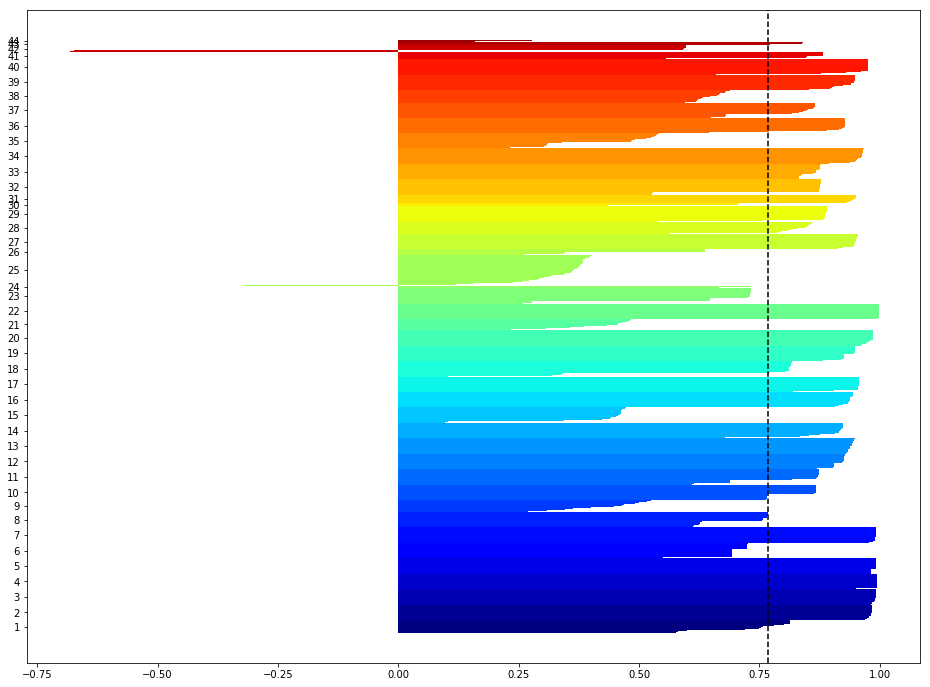

In [22]:

plt.rcParams["figure.figsize"] = [16,12]
silhouette_vals = silhouette_samples(Distances, Point_labels)
y_ax_lower, y_ax_upper = 0, 0
yticks=[]

Scores=[]
for i, c in enumerate(cluster_labels[1:]):
    Cluster_score = []
    c_silhouette_vals = silhouette_vals[Point_labels == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters_)
    ax = plt.barh(range(y_ax_lower,y_ax_upper),
            c_silhouette_vals,
            height = 1.0,
            edgecolor='none',
            color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
    Cluster_score.append(c_silhouette_vals)
    Scores.append([i, Cluster_score])
silhouette_avg = np.mean(silhouette_vals)
yline = plt.axvline(silhouette_avg,
            color = "black",
            linestyle="--")
yticks = plt.yticks(yticks, cluster_labels[1:] + 1)
plt.savefig('Visualizations/ssRNA_complete_100_subsample_50000_sihouette.pdf')